<a href="https://colab.research.google.com/github/SJin765/class_AI4dl/blob/main/Graph_Competition/EfficientDet_train_0609_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benetech | EfficientDet [Train]

https://www.kaggle.com/code/alejopaullier/benetech-efficientdet-train

Benetech | Create Bounding Box Dataframe

https://www.kaggle.com/code/alejopaullier/benetech-create-bounding-box-dataframe

# Import EfficientDet, Pytorch

In [1]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00


In [3]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/albumentations")

import albumentations as A
import copy
import cv2
import gc
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import PIL
import random
import time
import timm
import torch
import torch.nn as nn


from albumentations.pytorch.transforms import ToTensorV2
from colorama import Fore, Back, Style
from datetime import datetime, timedelta
from glob import glob
from pprint import pprint
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import lr_scheduler
from tqdm import tqdm


c_  = Fore.GREEN
sr_ = Style.RESET_ALL
print(f"There are {multiprocessing.cpu_count()} CPUs available")
print()
!mkdir logs
!mkdir saved_models

There are 2 CPUs available



# Value Error 대처 시도

Value error를 해결하기 위한 방법


: albumentations 패키지를 이용한 Augmentation 과정에서 문제가 생겼을 가능성이 큼.
albumentations 패키지 설치 위치의 bbox_utils.py 파일 을 수정해야함.
코랩은 직접적인 패키지 로컬파일 수정 기능을 제공하지 않으므로, 미리 수정해둔 bbox_utils.py 파일을 코랩에 업로드 한 후 덮어씌우는 방식으로 수정.

In [ ]:
# 추가하여 수정할 코드

def normalize_bbox(bbox: Sequence, rows: int, cols: int) -> Tuple:
x_min, x_max = max(0, x_min / cols), min(1, x_max / cols)
y_min, y_max = max(0, y_min / rows), min(1, y_max / rows)

def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
   #my added block 
    bbox=list(bbox)
    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1
    bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [5]:
# albumentations 패키지 경로 알아보기
print(A.__file__)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py


In [30]:
# 수정한 bbox_utils.py 업로드 후 패키지 파일 교체
import os
os.rename('/bbox_utils.py', '/usr/local/lib/python3.10/dist-packages/albumentations/core/bbox_utils.py')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

## Hyperparameter

In [ ]:
# 구글 드라이브에 내가 올려놓은 파일을 이용할 경우
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# file_path = '/content/drive/MyDrive/benetech-making-graphs-accessible'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 드라이브 내 압축풀기
import zipfile

zip_file_path = '/content/drive/MyDrive/benetech-making-graphs-accessible.zip'
extract_path = '/content/drive/MyDrive/benetech-making-graphs-accessible'

# 압축 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # 압축 파일 내 폴더 목록 확인
    folder_list = [name for name in zip_file.namelist() if name.endswith('/')]

    # 폴더 내용물 확인
    for folder_name in folder_list:
        print(f"Folder: {folder_name}")
        file_list = zip_file.namelist()

        # 폴더 내 파일 목록 확인
        for file_name in file_list:
            if file_name.startswith(folder_name) and not file_name.endswith('/'):
                print(f"File: {file_name}")

    # 압축 파일 해제
    zip_file.extractall(extract_path)

In [11]:
class config:
    BATCH_SIZE_TRAIN = 4
    BATCH_SIZE_VALID = 2
    DEBUG = False
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    EPOCHS = 5
    FOLDS = 5
    LR = 2e-4
    MIN_LR = 1e-6
    NUM_WORKERS = multiprocessing.cpu_count()
    RESOLUTION = 512
    SAMPLE = 30_000
    SEED = 42
    SCHEDULER = 'CosineAnnealingLR'
    T_0 = 25
    T_MAX = int(30_000/BATCH_SIZE_TRAIN*EPOCHS)+50
    WARMUP_EPOCHS = 0
    WEIGHT_DECAY = 1e-6
    
    
class paths:
    TRAIN_ANNOTATIONS_FOLDER = "/content/drive/MyDrive/benetech-making-graphs-accessible/train/annotations/"
    TRAIN_IMAGES_FOLDER = "/content/drive/MyDrive/benetech-making-graphs-accessible/train/images/"

## Utils

In [12]:
def get_stoi(df):
    """Get String to Index dictionary"""
    stoi = {}
    for idx, string in enumerate(df.label.unique()):
        stoi[string] = idx + 1
    itos = {item[1]: item[0] for item in stoi.items()}
    df = df.replace({"label": stoi})
    return stoi


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED)

## Create Bounding Box Dataframe

In [13]:
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil


from glob import glob
from tqdm import tqdm

!mkdir images

In [14]:
def extract_plot_bb(data):
    x0 = data["plot-bb"]["x0"]
    y0 = data["plot-bb"]["y0"]
    w = data["plot-bb"]["width"]
    h = data["plot-bb"]["height"]
    return [x0, y0, w, h, "plot-bb"]


def extract_label_bbox(data, rows, img_id):
    common = []
    common+= [img_id, data["source"], data["chart-type"]]
    for box in data["text"]:
        x0 = box["polygon"]["x0"]
        y0 = box["polygon"]["y0"]
        w = box["polygon"]["x1"] - box["polygon"]["x0"]
        h = box["polygon"]["y3"] - box["polygon"]["y0"]
        label = box["role"]
        box_row = common + [x0, y0, w, h, label]
        rows.append(box_row)
    rows.append(common + extract_plot_bb(data)) 
    return rows
        
def extract_tick_bbox(data, rows, img_id):
    common = []
    common+= [img_id , data["source"], data["chart-type"]]
    for axis in data["axes"].keys():
        for box in data["axes"][axis]["ticks"]:
            x0 = box["tick_pt"]["x"] - 5
            y0 = box["tick_pt"]["y"] - 5
            w = 10
            h = 10
            label = axis + "-tick"
            box_row = common + [x0, y0, w, h, label]
            rows.append(box_row)
    return rows

In [ ]:
# 자신의 train 데이터 annotations 폴더 지정
ANNOTATION = "/content/drive/MyDrive/benetech-making-graphs-accessible/train/annotations/*.json"
rows = []
for file_name in tqdm(glob(ANNOTATION)):
    label_bbox = []
    tick_bbox = []
    with open(file_name) as f:
        data = json.load(f)
        img_id = file_name.split("/")[-1].split(".")[0]
        label_bbox = extract_label_bbox(data, label_bbox, img_id)
        tick_bbox = extract_tick_bbox(data, tick_bbox, img_id)
        data_rows = label_bbox + tick_bbox
    rows += data_rows

100%|██████████| 60578/60578 [2:56:33<00:00,  5.72it/s]


In [ ]:
df = pd.DataFrame(rows)
df.columns = ["image_id", "source", "chart", "x0", "y0", "w", "h", "label"]
df.head()

,image_id,source,chart,x0,y0,w,h,label
0,fd8081cbe148,generated,vertical_bar,185,12,99,17,chart_title
1,fd8081cbe148,generated,vertical_bar,17,60,11,114,axis_title
2,fd8081cbe148,generated,vertical_bar,237,255,53,11,axis_title
3,fd8081cbe148,generated,vertical_bar,33,43,27,12,tick_label
4,fd8081cbe148,generated,vertical_bar,33,63,27,11,tick_label


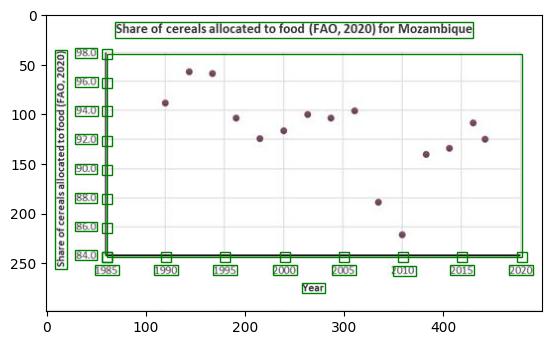

In [ ]:
# bounding box 시각화
import matplotlib.patches as patches
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,15)
image_id = random.choice(df["image_id"].unique().tolist())
sample = df[df["image_id"]==image_id]
for index, row in sample.iterrows():
    x0, y0, W, H = row["x0"], row["y0"], row["w"], row["h"]
    rect = patches.Rectangle((x0, y0), W, H,
                             linewidth=1,
                             edgecolor='g',
                             facecolor='none')
    ax.add_patch(rect)

TRAIN_FOLDER = "/content/drive/MyDrive/benetech-making-graphs-accessible/train/images/"
image = cv2.imread(TRAIN_FOLDER + image_id + ".jpg")

# Display the image
ax.imshow(image)
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/benetech-making-graphs-accessible/train/train.csv", index=False)

## Load Competition Data

In [15]:
df = pd.read_csv("/content/drive/MyDrive/benetech-making-graphs-accessible/train/train.csv")
print(f"Dataframe shape is: {df.shape}")
df.head()

Dataframe shape is: (2600412, 8)


,image_id,source,chart,x0,y0,w,h,label
0,fd8081cbe148,generated,vertical_bar,185,12,99,17,chart_title
1,fd8081cbe148,generated,vertical_bar,17,60,11,114,axis_title
2,fd8081cbe148,generated,vertical_bar,237,255,53,11,axis_title
3,fd8081cbe148,generated,vertical_bar,33,43,27,12,tick_label
4,fd8081cbe148,generated,vertical_bar,33,63,27,11,tick_label


## Data Pre-procesing

In [16]:
image_ids = df["image_id"].unique().tolist()
image_ids = random.sample(image_ids, config.SAMPLE)
filter = df[(df["x0"]<0) | (df["y0"]<0) | (df["h"]<=0) | (df["w"]<=0)].index
df = df[~df.index.isin(filter)]
df = df[df["image_id"].isin(image_ids)]
stoi = get_stoi(df)
pprint(stoi)
config.NUM_CLASSES =  len(stoi)
df = df[df["label"].isin(list(stoi.keys()))]
df = df.replace({"label": stoi})
df.reset_index(inplace=True)
print(f"Dataframe shape is: {df.shape}")
print(f"Number of classes: {config.NUM_CLASSES}")
df.head()

{'axis_title': 2,
 'chart_title': 1,
 'legend_label': 9,
 'other': 7,
 'plot-bb': 4,
 'tick_grouping': 8,
 'tick_label': 3,
 'x-axis-tick': 5,
 'y-axis-tick': 6}
Dataframe shape is: (1287759, 9)
Number of classes: 9


,index,image_id,source,chart,x0,y0,w,h,label
0,0,fd8081cbe148,generated,vertical_bar,185,12,99,17,1
1,1,fd8081cbe148,generated,vertical_bar,17,60,11,114,2
2,2,fd8081cbe148,generated,vertical_bar,237,255,53,11,2
3,3,fd8081cbe148,generated,vertical_bar,33,43,27,12,3
4,4,fd8081cbe148,generated,vertical_bar,33,63,27,11,3


In [ ]:
df

## Split into train, validation

In [17]:
gkf = GroupKFold(n_splits=config.FOLDS) # Seed for reproducibility
X = df.loc[:, df.columns != "label"]
y = df.loc[:, df.columns == "label"]
groups = df.loc[:, df.columns == "image_id"]

for fold, (train_index, val_index) in enumerate(gkf.split(X, y, groups)):
    df.loc[val_index, 'fold'] = int(fold) # Assign to each row its Fold ID
display(df.groupby(['fold','chart'])["index"].count())

fold  chart         
0.0   dot                19513
      horizontal_bar       168
      line              105882
      scatter            43341
      vertical_bar       88651
1.0   dot                19313
      horizontal_bar       117
      line              107314
      scatter            44381
      vertical_bar       86419
2.0   dot                19674
      horizontal_bar       238
      line              107182
      scatter            45436
      vertical_bar       85024
3.0   dot                20185
      horizontal_bar       300
      line              105249
      scatter            44771
      vertical_bar       87048
4.0   dot                18410
      horizontal_bar       296
      line              107903
      scatter            42216
      vertical_bar       88728
Name: index, dtype: int64

## Albumentations transformations



In [18]:
def get_train_transforms():
    return A.Compose(
        [
            A.Resize(height=config.RESOLUTION, width=config.RESOLUTION, p=1),
            A.Normalize(p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc', min_area=0,  min_visibility=0, label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=config.RESOLUTION, width=config.RESOLUTION, p=1.0),
            A.Normalize(p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
        )
    )

## Create custom PyTorch dataset

In [19]:
class CustomDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df # pandas dataframe
        self.transforms = transforms # albumentations transformations
        self.image_ids = self.df["image_id"].unique().tolist() # list with unique image IDs

    def __getitem__(self, index: int):
        """
        :return image: an augmented image as a numpy array.
        :return target: a dictionary containing a tensor with the bboxes for the image (torch.Tensor),
        a list of strings containing the bboxes labels and a tensor containing the image index.
        :return image_id: the image ID. A unique identifier for each image. 
        
        """
        image_id = self.image_ids[index] # select one image
        image, boxes = self.load_image_and_boxes(index) # load the image and its associated bounding boxes
        labels = self.get_labels(index)
        target = {
            'boxes' : boxes, 
            'labels' : labels, 
            'index' : torch.tensor([index])
        }
        transformed_image = self.transforms(**{
            'image': image,
            'bboxes': target['boxes'],
            'labels': target["labels"]
        })
        image = transformed_image['image']
        _, new_h, new_w = image.shape
        
        # This creates a torch tensor of size (number_bboxes, 4) where each row is a bounding box:
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*transformed_image['bboxes'])))).permute(1, 0)
        target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  # Required: change order to: (y, x, y, x)
        target["img_size"] = (new_h, new_w)
        target["img_scale"] = torch.tensor([1.0])
        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)

    def load_image_and_boxes(self, index):
        """
        :return image: the image as a numpy array. The array is scaled to the [0,1] interval. Numpy array.
        :return boxes: an array containing bounding boxes rows = [x0, y0, x0 + height, y0 + width]. List of lists.
        """
        image_id = self.image_ids[index] # select image
        image = cv2.imread(f'{paths.TRAIN_IMAGES_FOLDER}{image_id}.jpg', cv2.IMREAD_COLOR) # read image from path
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) # convert to RGB 
        records = self.df[self.df['image_id'] == image_id] # select all rows corresponding to the image
        boxes = records[['x0', 'y0', 'w', 'h']].values # get bounding box information
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x0 + Δx (or also  x0 + height), pascal_voc format
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y0 + Δy (or also  y0 + width), pascal_voc format
        boxes = boxes.tolist() # convert to list
        return image, boxes
    
    def get_labels(self, index):
        image_id = self.image_ids[index]
        labels = self.df[self.df['image_id'] == image_id]["label"].values.tolist()
        labels = torch.tensor(labels)
        return labels

## Prepare dataloaders

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))


def prepare_loaders(fold, df):
    """
    Splits data into Train and Validation sets depending on the current fold. Creates PyTorch
    datasets from the splits. Creates DataLoaders from Datasets.
    :param fold: current fold (int).
    :param df: train dataframe (pandas dataframe).
    :return train_loader, valid_loader: dataloaders for each stage.
    """
    # === Select data for Train and Validation ===
    train_df = df.query("fold!=@fold").reset_index(drop=True) # Select all rows not from validation fold
    valid_df = df.query("fold==@fold").reset_index(drop=True) # Select all rows from validation fold
    
    # === Mini sample for debugging purposes ===
    if config.DEBUG:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    
    # === Build Datasets ===
    train_dataset = CustomDataset(train_df, transforms=get_train_transforms())
    valid_dataset = CustomDataset(valid_df, transforms=get_valid_transforms())
    
    # === Create DataLoaders for Train and Validation ===
    train_loader = DataLoader(train_dataset, 
                              batch_size=config.BATCH_SIZE_TRAIN if not config.DEBUG else 20, 
                              num_workers=config.NUM_WORKERS,
                              sampler=RandomSampler(train_dataset),
                              pin_memory=False, drop_last=False, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID if not config.DEBUG else 20, 
                              num_workers=config.NUM_WORKERS,
                              sampler=SequentialSampler(valid_dataset),
                              shuffle=False, pin_memory=True, collate_fn=collate_fn)
    
    return train_loader, valid_loader


train_loader, valid_loader = prepare_loaders(fold=0, df=df)

## Scheduler

In [21]:
def fetch_scheduler(optimizer):
    if config.SCHEDULER == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=config.T_MAX, 
                                                   eta_min=config.MIN_LR)
    elif config.SCHEDULER == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=config.T_0, 
                                                             eta_min=config.MIN_LR)
    elif config.SCHEDULER == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=config.MIN_LR,)
    elif config.SCHEDULER == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif config.SCHEDULER == None:
        return None
        
    return scheduler

# Model

## Create training Model

In [22]:
!pip install effdet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=61653f54e1730f8658caac6d13a1d27b5f8c2db6bb37db1a69a00e8d6020987a
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [23]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

def create_model(num_classes=config.NUM_CLASSES, image_size=512,
                 architecture="tf_efficientnetv2_s", verbose=False):
    
    efficientdet_model_param_dict['tf_efficientnetv2_s'] = dict(
        name='tf_efficientnetv2_s',
        backbone_name='tf_efficientnetv2_s',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='')
    
    cfg = get_efficientdet_config(architecture)
    cfg.update({'num_classes': num_classes})
    cfg.update({'image_size': (image_size, image_size)})
    
    if verbose:
        pprint(cfg)

    net = EfficientDet(cfg, pretrained_backbone=True)
    net.class_net = HeadNet(
        cfg,
        num_outputs=cfg.num_classes,
    )
    return DetBenchTrain(net, cfg)


def load_model(model_weights_path, model):
    """
    Load model weights.
    """
    model.load_state_dict(torch.load(model_weights_path))
    model.eval()
    return model

## Average Meter : Track metrics and loss

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        """Initializes an instance by reseting its values"""
        self.reset()

    def reset(self):
        """Resets all values to zero"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        Tracks values, count, sum and average.
        :param val: usually the loss function value.
        :param n: usually the number of samples.
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train Function : 1 epoch

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train() # Set model in training mode
    loss_meter = AverageMeter() # Create instance
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ') # Progress bar
    for step, (images, targets, image_ids) in pbar:
        # === Collate ===
        images = torch.stack(images).to(device).float() # Get images (batch_size, 3, RESOLUTION, RESOLUTION)
        batch_size = images.shape[0] # Get batch size
        boxes = [target['boxes'].to(device).float() for target in targets] # Get bounding boxes
        labels = [target['labels'].to(device).float() for target in targets] # Get labels (tuple with strings)
        img_size = torch.tensor([target["img_size"] for target in targets]).to(device).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).to(device).float()
        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale
        }
        optimizer.zero_grad() # Zero out gradients
        loss = model(images, annotations) # Forward pass
        loss = loss["loss"]
        loss.backward() # Back propagation
        # Since the reduction type of the loss is "mean" we multiply by batch_size
        loss_meter.update(loss.detach().item(), batch_size) # Update loss
        optimizer.step() # Update params
        scheduler.step() # Update learning rate
        
        # === Evaluate model ===
        
        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0 # Track memory
        current_lr = optimizer.param_groups[0]['lr'] # Get current Learning Rate
        pbar.set_postfix(train_loss=f'{loss_meter.avg:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')
    # === Release memory ===
    torch.cuda.empty_cache()
    gc.collect()
    
    return loss_meter

## Validation Function : 1 epoch

In [26]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval() # Set model in evaluation mode
    loss_meter = AverageMeter() # Create instance
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ') # Progress bar
    for step, (images, targets, image_ids) in pbar:  
        # === Collate ===
        images = torch.stack(images).to(device).float() # Get images
        batch_size = images.shape[0] # Get batch size
        boxes = [target['boxes'].to(device).float() for target in targets] # Get boxes
        labels = [target['labels'].to(device).float() for target in targets] # Get labels
        img_size = torch.tensor([target["img_size"] for target in targets]).to(device).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).to(device).float()
        
        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale
        }
        loss = model(images, annotations) # Forward pass
        loss = loss["loss"]
        loss_meter.update(loss.detach().item(), batch_size) # Update loss
        # === Evaluate model ===
        
        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0 # Track memory
        current_lr = optimizer.param_groups[0]['lr'] # Get current learning rate
        pbar.set_postfix(valid_loss=f'{loss_meter.avg:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_memory=f'{mem:0.2f} GB')
    # === Release memory ===
    torch.cuda.empty_cache()
    gc.collect()
    
    return loss_meter

## Train Loop

In [27]:
def train_loop(model, optimizer, scheduler, device, num_epochs):
    f = open(f"/content/drive/MyDrive/benetech-making-graphs-accessible/working/logs/logs.txt", "w+") # Create log file
    
    if torch.cuda.is_available(): # Check if GPU is available
        print("Cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time() # Track execution time
    best_model_weights = copy.deepcopy(model.state_dict())
    epochs = config.EPOCHS
    best_loss = 1e10
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}', end='')
        loss_meter_train = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=config.DEVICE, epoch=epoch)
        
        loss_meter_valid = valid_one_epoch(model, valid_loader, 
                                           device=config.DEVICE, 
                                           epoch=epoch)
        
        duration = str(timedelta(seconds=time.time() - start))[:7]
        # === Print to log file ===
        with open(f"logs/logs.txt", 'a+') as f:
            print('{} | Epoch: {}/{} | Train Loss: {:.4} '. \
            format(duration, epoch + 1, epochs, loss_meter_train.avg), file=f)
            print('{} | Epoch: {}/{} | Valid Loss: {:.4}'. \
            format(duration, epoch + 1, epochs, loss_meter_valid.avg), file=f)
            print("\n" + "-"*100 + "\n", file=f)
        
        # === Save model if there is an improvement ===
        if loss_meter_valid.avg < best_loss:
            best_loss = loss_meter_valid.avg
            best_epoch = epoch
            best_model_weights = copy.deepcopy(model.state_dict())
            PATH = f"/content/drive/MyDrive/benetech-making-graphs-accessible/working/saved_models/best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved | Best Epoch {best_epoch} | Best Loss {round(best_loss,2)} {sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    return model

## Training

In [33]:
for fold in range(1):
    print(f'================= Fold: {1} =================')
    train_loader, valid_loader = prepare_loaders(fold=fold, df=df)
    model = create_model()
    model.to(config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = fetch_scheduler(optimizer)
    model = train_loop(model, optimizer, scheduler,
                       device=config.DEVICE,
                       num_epochs=config.EPOCHS)

================= Fold: 1 =================
Cuda: Tesla T4

Epoch 1/5

Train :   1%|          | 51/6000 [00:58<1:53:39,  1.15s/it, gpu_mem=5.62 GB, lr=0.00020, train_loss=751.5183]


ValueError: ignored

# Inference

## Install

## Import

In [ ]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/albumentations")

import albumentations as A
import copy
import cv2
import gc
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import PIL
import random
import time
import timm
import torch
import torch.nn as nn


from albumentations.pytorch.transforms import ToTensorV2
from colorama import Fore, Back, Style
from datetime import datetime, timedelta
from glob import glob
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from tqdm import tqdm


c_  = Fore.GREEN
sr_ = Style.RESET_ALL
print(f"There are {multiprocessing.cpu_count()} CPUs available")
print()
!mkdir logs
!mkdir saved_models

There are 2 CPUs available

mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘saved_models’: File exists


## Config

In [ ]:
class config:
    BATCH_SIZE_TEST = 4
    DEBUG = False
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    NUM_CLASSES = 7
    NUM_WORKERS = multiprocessing.cpu_count()
    RESOLUTION = 512
    SEED = 42
    
    
class paths:
    TEST_IMAGES_FOLDER = "/content/drive/MyDrive/benetech-making-graphs-accessible/test/images/"

## Utils

In [ ]:
stoi = {
    'chart_title': 1,
    'axis_title': 2,
    'tick_label': 3,
    'x-axis-tick': 4,
    'y-axis-tick': 5,
    'other': 6,
    'tick_grouping': 7,
    'legend_label': 8
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED)

## Load test data

In [ ]:
df = pd.DataFrame(glob(paths.TEST_IMAGES_FOLDER+"*.jpg"))
df.columns = ["image_path"]
df["image_id"] = df["image_path"].apply(lambda x: x.split("/")[-1].split(".")[0])
print(f"Dataframe shape is: {df.shape}")
df.head()

Dataframe shape is: (5, 2)


,image_path,image_id
0,/content/drive/MyDrive/benetech-making-graphs-...,000b92c3b098
1,/content/drive/MyDrive/benetech-making-graphs-...,01b45b831589
2,/content/drive/MyDrive/benetech-making-graphs-...,007a18eb4e09
3,/content/drive/MyDrive/benetech-making-graphs-...,00f5404753cf
4,/content/drive/MyDrive/benetech-making-graphs-...,00dcf883a459


## Data Augmentation

In [ ]:
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(height=config.RESOLUTION, width=config.RESOLUTION, p=1),
            A.Normalize(p=1),
            ToTensorV2(p=1.0),
        ]
    )

## Create Dataset

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df # pandas dataframe
        self.transforms = transforms # albumentations transformations
        self.image_ids = self.df["image_id"].unique().tolist() # list with unique image IDs

    def __getitem__(self, index: int):
        """
        :return image: an augmented image as a numpy array.
        :return target: a dictionary containing a tensor with the bboxes for the image (torch.Tensor),
        a list of strings containing the bboxes labels and a tensor containing the image index.
        :return image_id: the image ID. A unique identifier for each image. 
        
        """
        image_id = self.df["image_id"][index] # select one image
        image = cv2.imread(f'{paths.TEST_IMAGES_FOLDER}{image_id}.jpg', cv2.IMREAD_COLOR) # read image from path
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) # convert to RGB 
        transformed_image = self.transforms(**{"image":image})
        image = transformed_image['image']
        return image, image_id

    def __len__(self) -> int:
        return len(self.image_ids)

## Plot 1 image

Image ID: 000b92c3b098


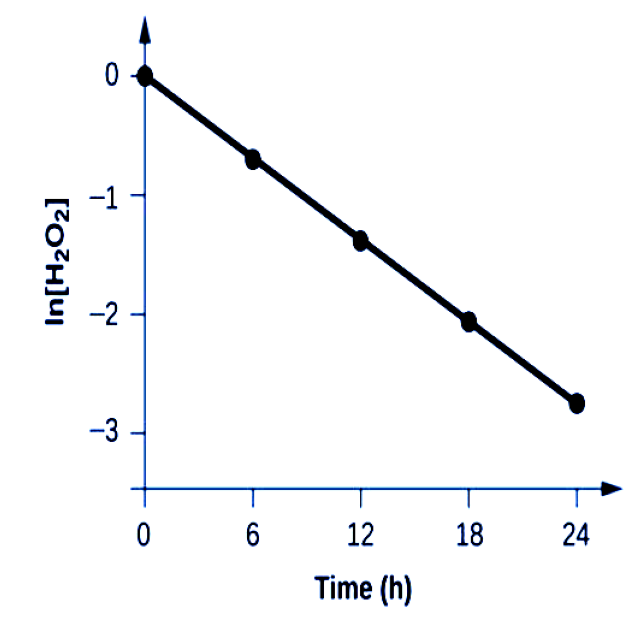

In [ ]:
test_dataset = CustomDataset(
    df=df,
    transforms=get_test_transforms()
)
index = random.choice(range(0,len(test_dataset))) # select random image index
image, image_id = test_dataset[index] # get one sample from dataset
numpy_image = image.permute(1,2,0).cpu().numpy() # get image
print(f"Image ID: {image_id}")   
fig, ax = plt.subplots(1, 1, figsize=(10, 8)) # create figure
ax.set_axis_off()
ax.imshow(numpy_image)

## Dataloaders

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


def prepare_loaders(df):
    """
    Creates a PyTorch dataset. Creates DataLoader from Dataset.
    :param df: test dataframe (pandas dataframe).
    :return test_loader: dataloaders for test stage.
    """
    # === Select data for Train and Validation ===
    test_df = df.reset_index(drop=True) # Select all rows not from validation fold
    
    # === Build Datasets ===
    test_dataset = CustomDataset(test_df, transforms=get_test_transforms())
    
    # === Create DataLoaders for Train and Validation ===
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE_TEST, 
        num_workers=config.NUM_WORKERS,
        sampler=SequentialSampler(test_dataset),
        shuffle=False, pin_memory=True,
        drop_last=False, collate_fn=collate_fn
    )
    
    return test_loader

test_loader = prepare_loaders(df=df)

## Model

In [ ]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

def create_model(num_classes=config.NUM_CLASSES, image_size=512,
                 architecture="tf_efficientnetv2_s", verbose=False):
    efficientdet_model_param_dict['tf_efficientnetv2_s'] = dict(
        name='tf_efficientnetv2_s',
        backbone_name='tf_efficientnetv2_s',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    cfg = get_efficientdet_config(architecture)
    cfg.update({'num_classes': num_classes})
    cfg.update({'image_size': (image_size, image_size)})
    
    if verbose:
        pprint(cfg)

    net = EfficientDet(cfg, pretrained_backbone=True)
    net.class_net = HeadNet(
        cfg,
        num_outputs=cfg.num_classes,
    )
    return DetBenchPredict(net)


def load_model(model_weights_path, model):
    """
    Load model weights.
    """
    model.load_state_dict(torch.load(model_weights_path))
    model.eval()
    return model

## Create Models 

In [ ]:
best_model = create_model(num_classes=config.NUM_CLASSES, verbose=True)
best_model = load_model("/kaggle/input/benetech-model/best_epoch_model.bin", best_model)
best_model.to(config.DEVICE)

{'name': 'tf_efficientnetv2_s', 'backbone_name': 'tf_efficientnetv2_s', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 7, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

FileNotFoundError: ignored

## Inference Function

In [ ]:
@torch.no_grad()
def inference_function(model, dataloader, device):
    model.eval() # Set model in evaluation mode
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Test ') # Progress bar
    predictions = []
    ids = []
    for step, (images, image_ids) in pbar:  
        # === Collate ===
        images = torch.stack(images).to(device).float() # Get images
        batch_size = images.shape[0] # Get batch size
        preds = model(images).cpu().numpy().tolist()
        predictions += preds # Forward pass
        ids += image_ids
    return predictions, ids

## Inference

In [ ]:
test_loader = prepare_loaders(df=df)
predictions, image_ids = inference_function(best_model, test_loader, config.DEVICE)

## Prediction

In [ ]:
preds_df = pd.DataFrame([image_ids, predictions]).T
preds_df.columns = ["image_id", "prediction"]
preds_df = preds_df.explode("prediction")
cols = ['x_min', 'y_min', 'x_max', 'y_max', 'prob', 'label']
preds_df[cols] = pd.DataFrame(preds_df.prediction.tolist(), index= preds_df.index)
preds_df = preds_df[preds_df["prob"]>0.3]
preds_df

## Plot Prediction

In [ ]:
for image_id in preds_df.image_id.unique().tolist():
    aux = preds_df[preds_df["image_id"]==image_id]
    image = cv2.imread(paths.TEST_IMAGES_FOLDER + image_id + ".jpg")
    transform = A.Resize(height=config.RESOLUTION, width=config.RESOLUTION, p=1)
    transformed_image = transform(**{"image":image})
    image = transformed_image["image"]
    print(f"Image ID: {image_id}")
    fig, ax = plt.subplots(1, 1, figsize=(12, 10)) # create figure
    for index, row in aux.iterrows():
        x_min, x_max, y_min, y_max = int(row["x_min"]), int(row["x_max"]), int(row["y_min"]), int(row["y_max"])
        # === Plot bounding boxes ====
        cv2.rectangle(image, (x_min, y_min), (x_max,  y_max), (0, 255, 0), 2)
    ax.set_axis_off()
    ax.imshow(image)